# match DiaObject and TruthSummary

There are many more DiaObjects than true variables. Explore why.

**Hypothesis:** the DiaObjects with no true variable at their location are artifacts near stars.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import pandas
pandas.set_option('display.max_rows', 1000)

from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
import astropy.units as u

from lsst.rsp import get_tap_service

In [2]:
service = get_tap_service()

## get a bunch of DiaObjects

In [3]:
query = "SELECT ra, decl, diaObjectId, nDiaSources, " + \
        "rPSFluxMin, rPSFluxMax, rPSFluxMean, rPSFluxSigma, " + \
        "rPSFluxMAD, rPSFluxChi2, rPSFluxNdata, rPSFluxSkew, " + \
        "rPSFluxStetsonJ, rPSFluxPercentile05, rPSFluxPercentile25, " + \
        "rPSFluxPercentile50, rPSFluxPercentile75, rPSFluxPercentile95, " + \
        "rTOTFluxMean, rTOTFluxSigma " + \
        "FROM dp02_dc2_catalogs.DiaObject " + \
        "WHERE CONTAINS(POINT('ICRS', ra, decl), CIRCLE('ICRS', 61.5, -32.5, 0.5)) = 1"
print(query)

SELECT ra, decl, diaObjectId, nDiaSources, rPSFluxMin, rPSFluxMax, rPSFluxMean, rPSFluxSigma, rPSFluxMAD, rPSFluxChi2, rPSFluxNdata, rPSFluxSkew, rPSFluxStetsonJ, rPSFluxPercentile05, rPSFluxPercentile25, rPSFluxPercentile50, rPSFluxPercentile75, rPSFluxPercentile95, rTOTFluxMean, rTOTFluxSigma FROM dp02_dc2_catalogs.DiaObject WHERE CONTAINS(POINT('ICRS', ra, decl), CIRCLE('ICRS', 61.5, -32.5, 0.5)) = 1


In [4]:
%%time
results = service.search(query)
DiaObjs = results.to_table().to_pandas()
del results, query

CPU times: user 3.85 s, sys: 89.4 ms, total: 3.94 s
Wall time: 4.95 s


## get a bunch of true variables

Use the same area constraints.

In [5]:
query = "SELECT ra, dec, is_variable, truth_type " + \
        "FROM dp02_dc2_catalogs.TruthSummary " + \
        "WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', 61.5, -32.5, 0.5)) = 1 " + \
        "AND is_variable = 1"
print(query)

SELECT ra, dec, is_variable, truth_type FROM dp02_dc2_catalogs.TruthSummary WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', 61.5, -32.5, 0.5)) = 1 AND is_variable = 1


In [6]:
%%time
results = service.search(query)
TruthSum = results.to_table().to_pandas()
del results, query

CPU times: user 113 ms, sys: 1.79 ms, total: 114 ms
Wall time: 325 ms


### show there are many more DiaObjects than true variables in this area

In [7]:
print(len(DiaObjs), len(TruthSum))

99896 10534


## what are all these "extra" DiaObjects?

### match DiaObjs to TruthSum

In [8]:
DiaObjs_skycoords = SkyCoord(ra=DiaObjs.loc[:,'ra'].values*u.degree, \
                             dec=DiaObjs.loc[:,'decl'].values*u.degree)

In [9]:
TruthSum_skycoords = SkyCoord(ra=TruthSum.loc[:,'ra'].values*u.degree, \
                              dec=TruthSum.loc[:,'dec'].values*u.degree)

 * `idx` : index of nearest TruthSum for each DiaObjs
 * `d2d` : 2D separation to nearest TruthSum for each DiaObjs
 * `d3d` : array of 3D separations (ignore this)

In [10]:
idx, d2d, d3d = match_coordinates_sky(DiaObjs_skycoords, TruthSum_skycoords)

In [11]:
print(len(idx), len(d2d))

99896 99896


How many are "good" matches of DiaObjs to TruthSum?

In [12]:
tx = np.where(d2d.arcsec < 2.0)[0]
print(len(tx), np.round(float(len(tx))/float(len(DiaObjs)),2))
del tx

17010 0.17


### explore differences in matched/unmatched DiaObjs

Flag DiaObjs that are matched, so we can explore differences between matched and unmatched.

In [16]:
DiaObjs['my_match_flag'] = np.zeros(len(DiaObjs), dtype='int')

In [19]:
for i in range(len(DiaObjs['my_match_flag'])):
    if d2d[i].arcsec < 2.0:
        DiaObjs.loc[i, 'my_match_flag'] = 1

In [44]:
tx0 = np.where(DiaObjs['my_match_flag'] == 0)[0]
tx1 = np.where(DiaObjs['my_match_flag'] == 1)[0]
print(len(tx0), len(tx1))

82886 17010


#### number of DiaSources

Most unmatched DiaObjs have one DiaSource (i.e., one detection, as in, more likely spurious).

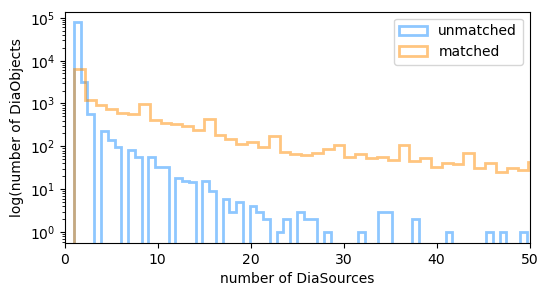

In [47]:
fig = plt.figure(figsize=(6, 3))

plt.hist(DiaObjs.loc[tx0, 'nDiaSources'], bins=300, color='dodgerblue', alpha=0.5, \
         histtype='step', lw=2, log=True, label='unmatched')
plt.hist(DiaObjs.loc[tx1, 'nDiaSources'], bins=300, color='darkorange', alpha=0.5, \
         histtype='step', lw=2, log=True, label='matched')

plt.legend(loc='upper right')
plt.xlim([0,50])
plt.xlabel('number of DiaSources')
plt.ylabel('log(number of DiaObjects')
plt.show()

#### rPSFluxMin vs. rPSFluxMax

Most unmatched DiaObjects are faint.

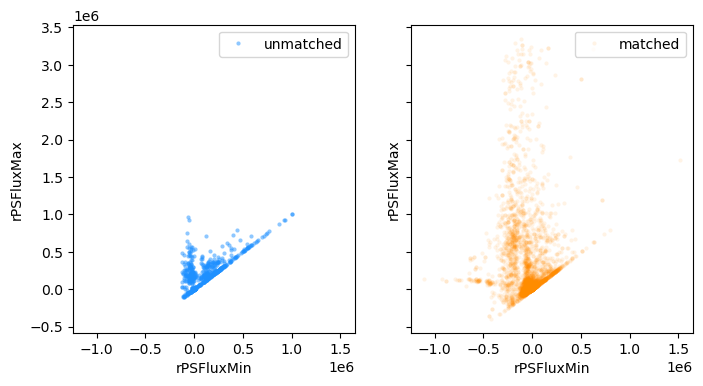

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax[0].plot(DiaObjs.loc[tx0, 'rPSFluxMin'], DiaObjs.loc[tx0, 'rPSFluxMax'], \
         'o', ms=3, alpha=0.1, mew=0, color='dodgerblue', label='unmatched')

ax[1].plot(DiaObjs.loc[tx1, 'rPSFluxMin'], DiaObjs.loc[tx1, 'rPSFluxMax'], \
         'o', ms=3, alpha=0.1, mew=0, color='darkorange', label='matched')

ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')
ax[0].set_xlabel('rPSFluxMin')
ax[0].set_ylabel('rPSFluxMax')
ax[1].set_xlabel('rPSFluxMin')
ax[1].set_ylabel('rPSFluxMax')
plt.show()

#### rTOTFluxMean vs rPSFluxMean

The TOTFluxMean for unmatched DiaObjs is NOT zero -- there's probably a star there.

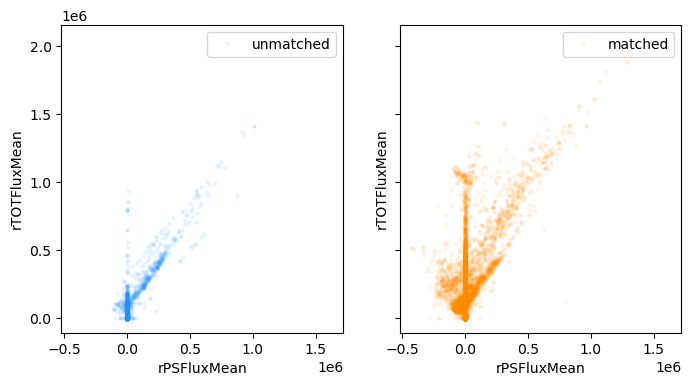

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax[0].plot(DiaObjs.loc[tx0, 'rPSFluxMean'], DiaObjs.loc[tx0, 'rTOTFluxMean'], \
         'o', ms=3, alpha=0.1, mew=0, color='dodgerblue', label='unmatched')

ax[1].plot(DiaObjs.loc[tx1, 'rPSFluxMean'], DiaObjs.loc[tx1, 'rTOTFluxMean'], \
         'o', ms=3, alpha=0.1, mew=0, color='darkorange', label='matched')

ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')
ax[0].set_xlabel('rPSFluxMean')
ax[0].set_ylabel('rTOTFluxMean')
ax[1].set_xlabel('rPSFluxMean')
ax[1].set_ylabel('rTOTFluxMean')
plt.show()

#### ra vs decl

This is very telling that many unmatched DiaObjects are associated with bright stars.

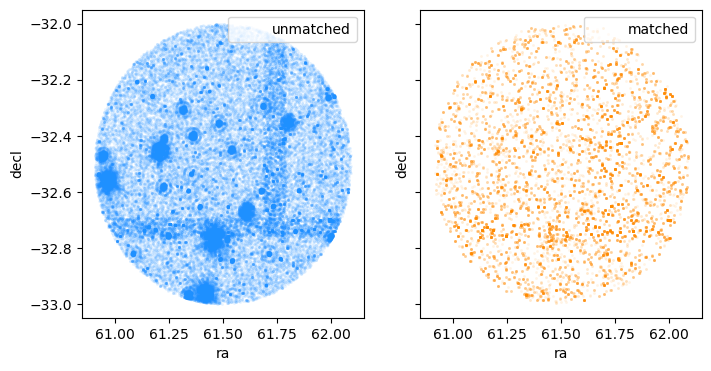

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax[0].plot(DiaObjs.loc[tx0, 'ra'], DiaObjs.loc[tx0, 'decl'], \
         'o', ms=2, alpha=0.1, mew=0, color='dodgerblue', label='unmatched')

ax[1].plot(DiaObjs.loc[tx1, 'ra'], DiaObjs.loc[tx1, 'decl'], \
         'o', ms=2, alpha=0.1, mew=0, color='darkorange', label='matched')

ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')
ax[0].set_xlabel('ra')
ax[0].set_ylabel('decl')
ax[1].set_xlabel('ra')
ax[1].set_ylabel('decl')
plt.show()